In [17]:
!pip install pennylane

In [2]:
import pennylane as qml
import pennylane.numpy as np
import networkx as nx
from pennylane.transforms import mitigate_with_zne
from matplotlib import pyplot as plt

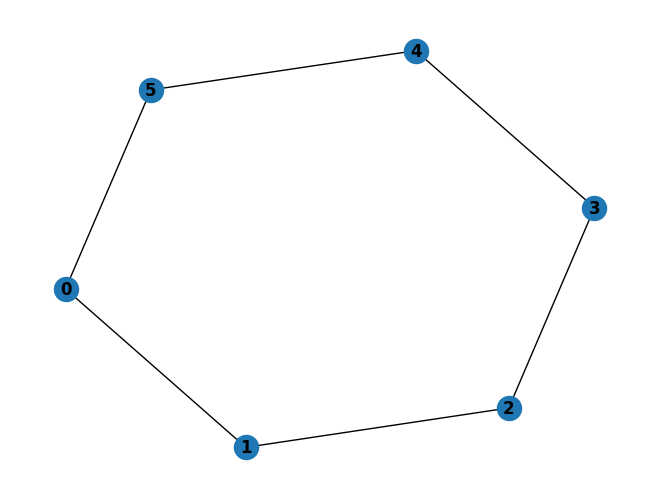

In [15]:
graph = nx.Graph(((0, 1), (1, 2), (2, 3), (3,4), (4,5), (5, 0)))
from pennylane.qaoa import maxcut
hamiltonian_maxcut, hamiltonian_mixer = maxcut(graph)
nx.draw(graph, with_labels=True, font_weight='bold')

In [4]:
obs = []
coeffs = []

for edge in graph.edges():
    coeffs.extend([1.0, 1.0, 1.0])
    obs.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
                        qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
                        qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
H = qml.Hamiltonian(coeffs, obs)
print(H)
num_qubits = len(H.wires)
print("\nVector space dimension: ", num_qubits)

  (1.0) [X0 X1]
+ (1.0) [Y0 Y1]
+ (1.0) [Z0 Z1]
+ (1.0) [X0 X5]
+ (1.0) [Y0 Y5]
+ (1.0) [Z0 Z5]
+ (1.0) [X1 X2]
+ (1.0) [Y1 Y2]
+ (1.0) [Z1 Z2]
+ (1.0) [X2 X3]
+ (1.0) [Y2 Y3]
+ (1.0) [Z2 Z3]
+ (1.0) [X3 X4]
+ (1.0) [Y3 Y4]
+ (1.0) [Z3 Z4]
+ (1.0) [X4 X5]
+ (1.0) [Y4 Y5]
+ (1.0) [Z4 Z5]

Vector space dimension:  6


In [5]:
n_layers = 2
w1 = np.ones((num_qubits), requires_grad=True)
w2 = np.ones((n_layers, num_qubits - 1, 2), requires_grad=True)
def ansatz_cost(w1, w2):
    qml.SimplifiedTwoDesign(w1, w2, wires=range(num_qubits))
    return qml.expval(H)

print(qml.draw(ansatz_cost)(w1,w2))

0: ─╭SimplifiedTwoDesign─┤ ╭<𝓗>
1: ─├SimplifiedTwoDesign─┤ ├<𝓗>
2: ─├SimplifiedTwoDesign─┤ ├<𝓗>
3: ─├SimplifiedTwoDesign─┤ ├<𝓗>
4: ─├SimplifiedTwoDesign─┤ ├<𝓗>
5: ─╰SimplifiedTwoDesign─┤ ╰<𝓗>


In [6]:
dev = qml.device("lightning.qubit", wires=num_qubits)
qn1 = qml.QNode(ansatz_cost,dev)
res1 = qn1(w1, w2)
res1

array(-0.97841002)

Let's optimize the square lattice using noise and mitigate using linear extrapolation of the zne method

In [10]:
noise_gate = qml.DepolarizingChannel #artificial noise
noise_strength = 0.025 #strength of kraus noise

dev_ideal = qml.device("default.mixed", wires=num_qubits) #comparative ideal noiseless device
dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength, position="all") #noisy device


scale_factors=[2]

qnode_ideal = qml.QNode(ansatz_cost, dev) # ideal qnode
qnode_noisy = qml.QNode(ansatz_cost, dev_noisy) #noisy qnode
qnode_mitigated = mitigate_with_zne(qnode_noisy,
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.poly_extrapolate, extrapolate_kwargs={'order': 2}
) # mitigated qnode

In [11]:
print("Ideal QNode: ", qnode_ideal(w1, w2))
print("Mitigated QNode: ", qnode_mitigated(w1, w2))
print("Noisy QNode: ", qnode_noisy(w1, w2))

Ideal QNode:  -0.9784100209985347
Mitigated QNode:  -0.12449660143047132
Noisy QNode:  -0.615606351940791


[<QNode: wires=6, device='default.mixed', interface='auto', diff_method='best'>] 




C:\Users\DELL\AppData\Local\Temp\ipykernel_1812\1059801168.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  drawing.show()


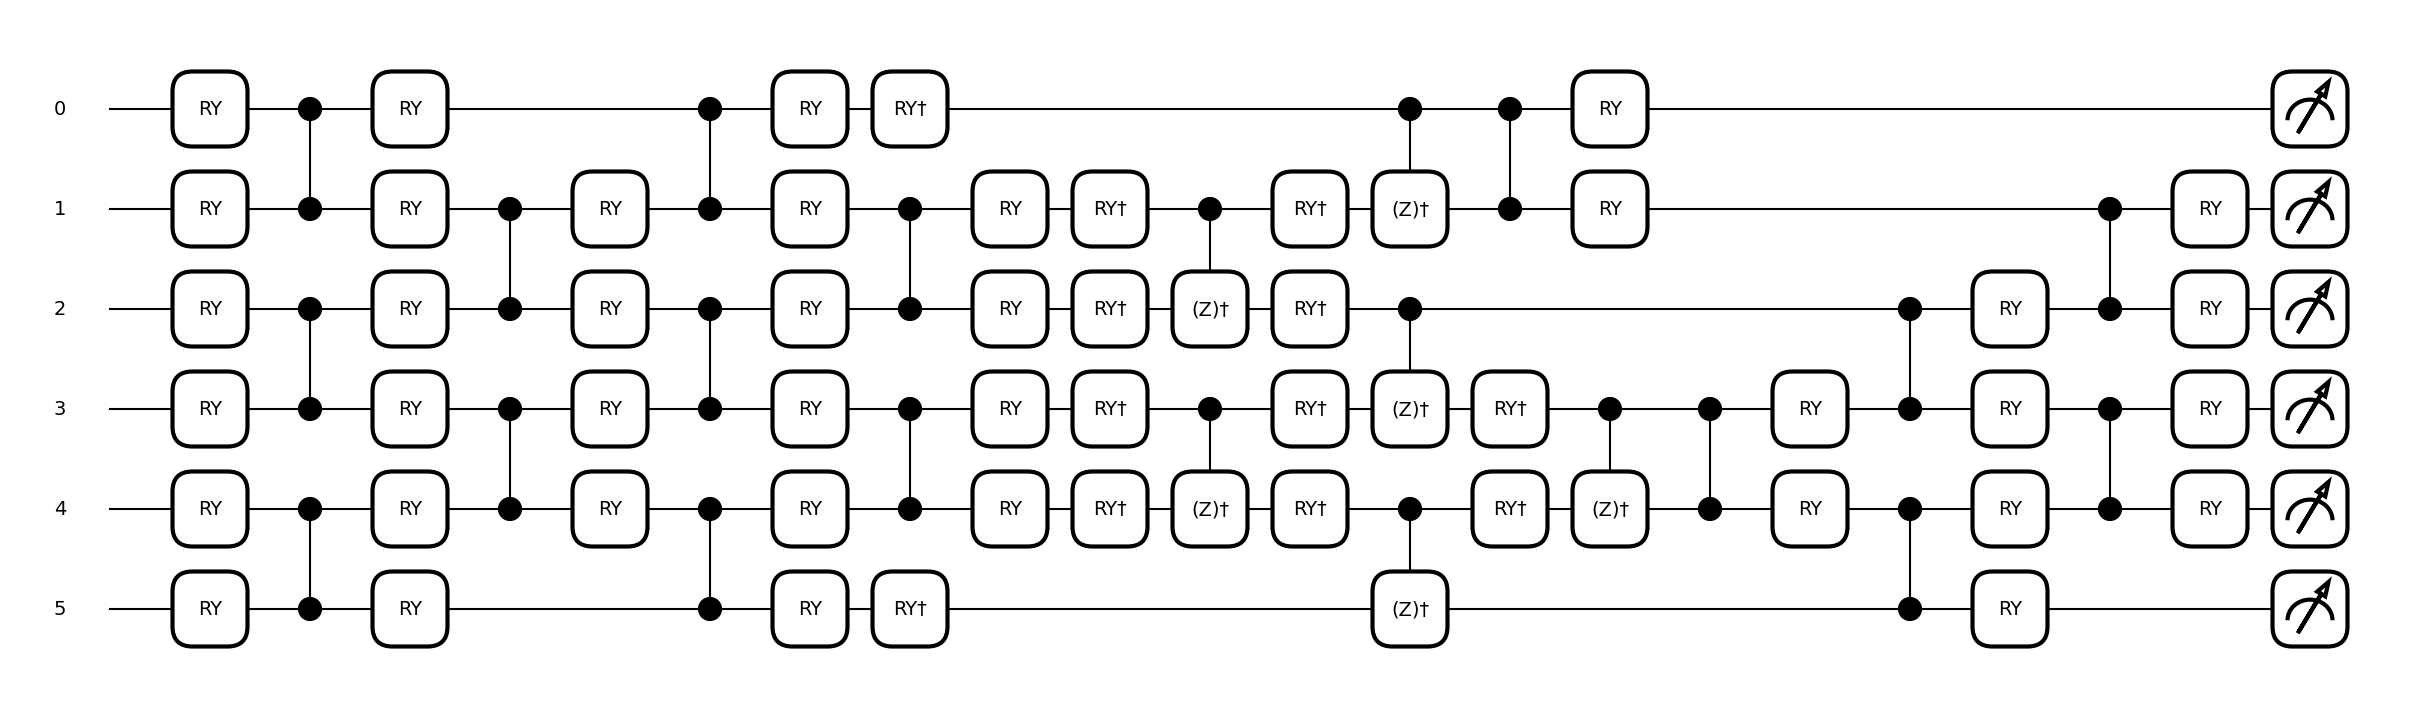

In [12]:
folded_circuits = [qml.transforms.fold_global(qnode_noisy, scale_factor) for scale_factor in scale_factors]
print(folded_circuits,"\n\n")

for i in range(len(folded_circuits)):
  drawing, ax = qml.draw_mpl(folded_circuits[i])(w1,w2)
  fig = drawing.figure
  """fig.set_figwidth(16)
  fig.set_figheight(2.5)"""
  drawing.show()

In [13]:
def VQE_run(cost_fn, max_iter, stepsize=0.1):
    """VQE Optimization loop"""
    opt = qml.SPSAOptimizer(maxiter= max_iter)

    # fixed initial guess
    w1 = np.ones((num_qubits), requires_grad=True)
    w2 = np.ones((n_layers, num_qubits - 1, 2), requires_grad=True)

    energy = []

    # Optimization loop
    for n in range(max_iter):
        (w1, w2), prev_energy = opt.step_and_cost(cost_fn, w1, w2)

        energy.append(prev_energy)
        if (n%50 == 0):
          print("Energy optimization at ",n,"th step is : ",energy[-1])

    energy.append(cost_fn(w1, w2)) # final addition to the last updated params
    print("Energy optimization at final step is : ",energy[-1],"\n")
    return energy # energy list


max_iter = 200

energy_ideal = VQE_run(qnode_ideal, max_iter)
energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(H)))
print("Exact Ground state: ",energy_exact)

Energy optimization at  0 th step is :  -0.9784100209985347
Energy optimization at  50 th step is :  -5.8259013168497
Energy optimization at  100 th step is :  -8.691448604180103
Energy optimization at  150 th step is :  -8.851657485093282
Energy optimization at final step is :  -8.907015991945135 

Exact Ground state:  -11.211102550927963


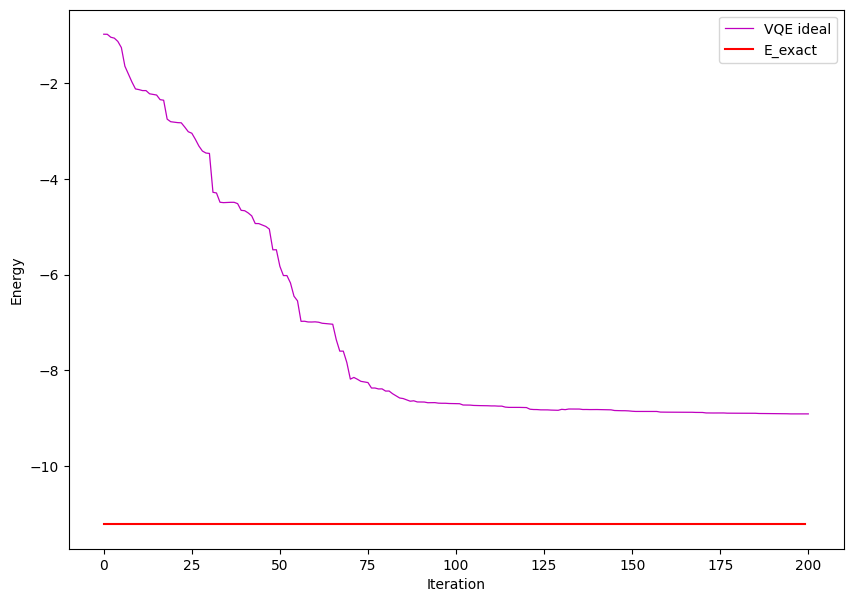

In [14]:
plt.figure(figsize=(10, 7))

plt.plot(energy_ideal, "-", label="VQE ideal", color = "m",linewidth = 0.9)
plt.plot(np.arange(stop=max_iter,step=1), [energy_exact]*max_iter, "-", label="E_exact", color = "r")
plt.legend(fontsize=10)

plt.xlabel("Iteration", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.show()

In [60]:
energy_noisy = VQE_run(qnode_noisy, max_iter)
energy_mitigated = VQE_run(qnode_mitigated, max_iter)

Energy optimization at  0 th step is :  -0.17567619546056712
Energy optimization at  50 th step is :  -3.6250502852438578
Energy optimization at  100 th step is :  -3.885766607114471
Energy optimization at  150 th step is :  -4.090607356491606
Energy optimization at final step is :  -4.259506833071753 

Energy optimization at  0 th step is :  -0.05479859372392845
Energy optimization at  50 th step is :  -0.29560964727277433
Energy optimization at  100 th step is :  -0.44961355275707576
Energy optimization at  150 th step is :  -0.5575788646997524
Energy optimization at final step is :  -0.6509549125129154 

Exact ground state:  -7.472135954999583
ideal optimization % error: -7.4677487365145865
mitigated optimization % error: -91.28823516551029


In [66]:
print("Exact ground state: ",np.abs(energy_exact))
print("Ideally optimized after",max_iter," epochs: ",energy_ideal[-1])
print("Mitigated result after",max_iter," epochs: ",energy_mitigated[-1])
print("ideal optimization error:",np.abs((energy_ideal[-1] - energy_exact)/energy_exact))
print("mitigated optimization error:",np.abs((energy_mitigated[-1] - energy_exact)/energy_exact))

Exact ground state:  7.472135954999583
Ideally optimized after 200  epochs:  -6.91413561662945
Mitigated result after 200  epochs:  -0.6509549125129154
ideal optimization error: 0.07467748736514587
mitigated optimization error: 0.9128823516551029


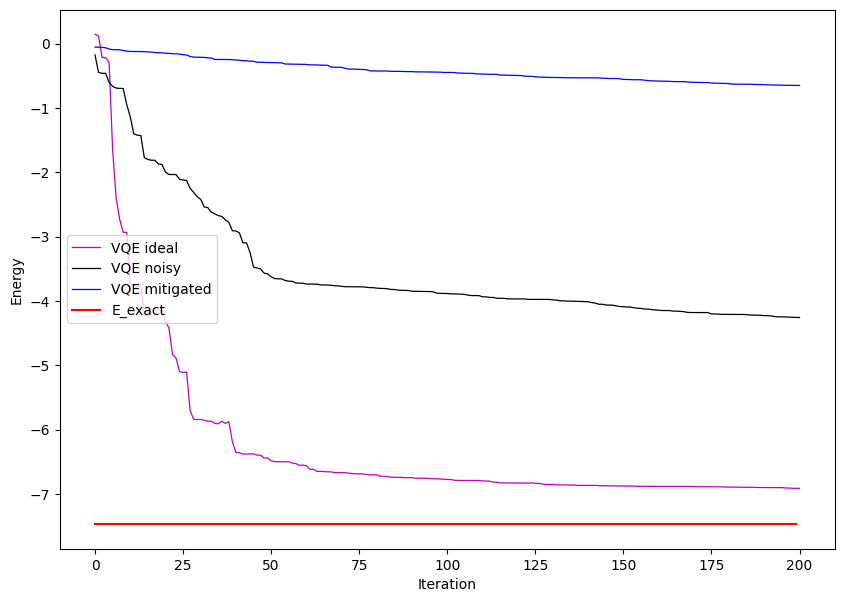

In [63]:
plt.figure(figsize=(10, 7))

plt.plot(energy_ideal, "-", label="VQE ideal", color = "m",linewidth = 0.9)
plt.plot(energy_noisy, "-", label="VQE noisy", color = "k",linewidth = 0.9)
plt.plot(energy_mitigated, "-", label="VQE mitigated", color = "b",linewidth = 0.9)
plt.plot(np.arange(stop=max_iter,step=1), [energy_exact]*max_iter, "-", label="E_exact", color = "r")
plt.legend(fontsize=10)

plt.xlabel("Iteration", fontsize=10)
plt.ylabel("Energy", fontsize=10)
plt.show()